In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sb

from pathlib import Path

from lola.plot import draw

os.environ["PATH"] += ":/mnt/sw/nix/store/80wb60hk9c9hbi1rzbnr6kdbbjknp4ch-texlive-20220321/bin/x86_64-linux"

outdir = Path("./figures")
outdir.mkdir(exist_ok=True)

rc = {
    "axes.axisbelow": True,
    "axes.linewidth": 1.0,
    "axes.labelsize": "x-small",
    "axes.titlesize": "x-small",
    "figure.dpi": 150,
    "figure.figsize": (3.2, 3.2),
    "font.size": 12.0,
    "legend.fontsize": "xx-small",
    "lines.linewidth": 1.0,
    "savefig.transparent": True,
    "xtick.labelsize": "xx-small",
    "xtick.major.width": 1.0,
    "ytick.labelsize": "xx-small",
    "ytick.major.width": 1.0,
    "font.family": ["serif"],
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{amsfonts}",
}

plt.rcParams.update(rc)

In [2]:
settings = "mean_absolute"

## Dataframe

In [3]:
df = pd.read_csv(
    "~/ceph/lola/results/gravity_cooling/stats.csv",
    names=[
        "run",
        "target",
        "compression",
        "method",
        "settings",
        "guidance",
        "context",
        "overlap",
        "speed",
        "split",
        "index",
        "start",
        "seed",
        "field",
        "time",
        "relative",
        "m1",
        "m2",
        "spread",
        "rmse",
        "nrmse",
        "vrmse",
        "re_total",
        "wasserstein",
        "emd",
        "rmse_p_low",
        "rmse_c_low",
        "rmse_p_mid",
        "rmse_c_mid",
        "rmse_p_high",
        "rmse_c_high",
        "rmse_p_sub",
        "rmse_c_sub",
        "density_init",
        "metallicity",
        "temperature_init",
        "bc00",
        "bc01",
        "bc10",
        "bc11",
        "bc20",
        "bc21",
    ],
    dtype={"settings": str, "guidance": str, "compression": int},
)

if "relative" in settings:
    df = df[df["relative"]]
elif "absolute" in settings:
    df = df[~df["relative"]]

df = df[df["time"] > 0]
df = df[df["start"] == 4]
df = df.sort_values(["method", "compression"], kind="stable")
df = df.merge(
    pd.DataFrame({
        "field": [0, 1, 2, 3, 4, 5],
        "std_global": [1.0, 1.75, 1.0, 0.5, 0.5, 0.5],
    })
)


def horizon(t):
    if t < 10:
        return "01:10"
    elif t < 30:
        return "11:30"
    else:
        return "31:50"


df["horizon"] = df["time"].apply(horizon)
df["std_instant"] = np.sqrt(df["m2"] - df["m1"] ** 2)
df["spread_skill"] = (df["spread"] + 1e-3) / (df["rmse"] + 1e-3)
df["method"] = df["method"].replace("surrogate", "neural solver")
df.loc[df["method"] == "neural solver", "spread_skill"] = 0.0

In [4]:
def aggregate(x):
    if "safemean" in settings:
        l, u = np.quantile(x, (1e-3, 1 - 1e-3))
        mask = np.logical_and(l <= x, x <= u)
        return np.mean(x[mask])
    elif "mean" in settings:
        return np.mean(x)
    elif "median" in settings:
        return np.median(x)

## Plots

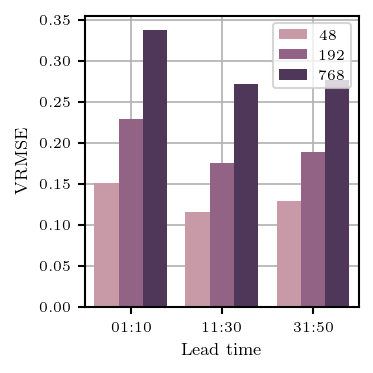

In [5]:
table = df[df["method"] == "autoencoder"]

fig = plt.figure(figsize=(2.4, 2.4))

ax = sb.barplot(
    table,
    x="horizon",
    y="vrmse",
    hue="compression",
    estimator=aggregate,
    errorbar=None,
    palette=sb.cubehelix_palette(4, dark=0.25)[1:],
)

ax.grid()
ax.get_legend().set_title(None)

ax.set_xlabel("Lead time")
ax.set_ylabel("VRMSE")

fig.tight_layout(pad=0.33)

plt.savefig(outdir / f"tgc_ae_{settings}.pdf", dpi=300, transparent=True)

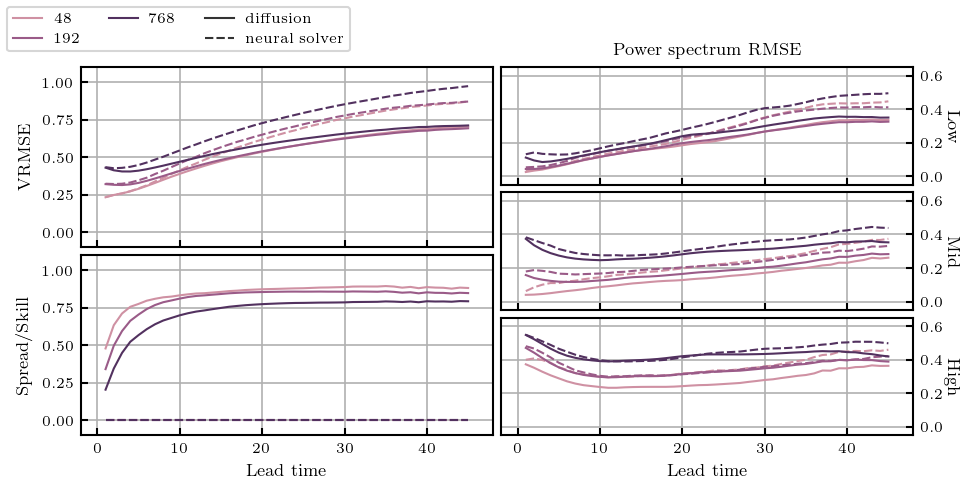

In [6]:
table = df[df["method"] != "autoencoder"]

fig, axs = plt.subplot_mosaic(
    [
        [0, 2],
        [0, 2],
        [0, 3],
        [1, 3],
        [1, 4],
        [1, 4],
    ],
    figsize=(6.4, 3.2),
    sharex=True,
    sharey=False,
)

for i, metric in enumerate(["VRMSE", "spread_skill"]):
    ax = sb.lineplot(
        table,
        x="time",
        y=metric.lower(),
        hue="compression",
        style="method",
        estimator=aggregate,
        errorbar=None,
        palette=sb.cubehelix_palette(4, dark=0.25)[1:],
        ax=axs[i],
    )

    ax.get_legend().remove()
    ax.grid()

    ax.set_xlabel("Lead time")
    ax.set_xlim(-2, 48)
    ax.set_ylim(-0.1, 1.1)

    if metric == "spread_skill":
        ax.set_ylabel("Spread/Skill")
    else:
        ax.set_ylabel(metric)

    ax.tick_params(direction="in")

    handles, labels = ax.get_legend_handles_labels()

for i, band in enumerate(["Low", "Mid", "High"], start=2):
    ax = sb.lineplot(
        table,
        x="time",
        y=f"rmse_p_{band.lower()}",
        hue="compression",
        style="method",
        estimator=aggregate,
        errorbar=None,
        palette=sb.cubehelix_palette(4, dark=0.25)[1:],
        ax=axs[i],
    )

    ax.get_legend().remove()
    ax.grid()

    ax.set_xlabel("Lead time")
    ax.set_xlim(-2, 48)

    ax.set_ylabel(band)
    ax.set_ylim(-0.05, 0.65)

    ax.tick_params(direction="in")

    ax.yaxis.set_label_position("right")
    ax.yaxis.label.set(rotation=-90, va="center")
    ax.yaxis.tick_right()

    if i == 2:
        ax.set_title("Power spectrum RMSE")

for i, label in reversed(list(enumerate(labels))):
    if label in ("compression", "method"):
        blank = handles.pop(i)
        labels.pop(i)

handles.insert(-2, blank)
labels.insert(-2, None)

fig.align_labels()
fig.tight_layout(pad=0.33)
fig.subplots_adjust(top=0.875)
fig.legend(handles, labels, loc="upper left", ncol=3)

plt.savefig(outdir / f"tgc_mosaic_{settings}.pdf", dpi=300, transparent=True)

## Tables

In [7]:
table = df[["method", "compression", "horizon", "vrmse"]]

table = table.groupby(["method", "compression", "horizon"]).agg(aggregate).round(3).reset_index()
table = table.pivot(index=["method", "compression"], columns="horizon", values=["vrmse"])
# print(table.to_latex(float_format="%.3f"))
table

vrmse              
horizon                    01:10  11:30  31:50
method        compression                     
autoencoder   48           0.151  0.116  0.129
              192          0.229  0.175  0.189
              768          0.338  0.272  0.276
diffusion     48           0.296  0.522  0.673
              192          0.342  0.527  0.665
              768          0.425  0.575  0.694
neural solver 48           0.302  0.599  0.826
              192          0.361  0.632  0.835
              768          0.462  0.710  0.920

In [8]:
table = df[(df["method"] != "autoencoder") & (df["compression"] > 1)]
table = table[["method", "context", "horizon", "vrmse"]]

table = table.groupby(["method", "context", "horizon"]).agg(aggregate).round(3).reset_index()
table = table.pivot(index=["method", "context"], columns="horizon", values=["vrmse"])
# print(table.to_latex(float_format="%.3f"))
table

vrmse              
horizon                01:10  11:30  31:50
method        context                     
diffusion     1        0.362  0.550  0.681
              2        0.351  0.535  0.669
              3        0.350  0.539  0.683
neural solver 1        0.376  0.632  0.837
              2        0.371  0.641  0.855
              3        0.378  0.669  0.888

In [9]:
table = df[["method", "compression", "horizon", "rmse_p_low", "rmse_p_mid", "rmse_p_high"]]

table = table.groupby(["method", "compression", "horizon"]).agg(aggregate).round(3).reset_index()
table = table.pivot(
    index=["method", "compression"],
    columns="horizon",
    values=["rmse_p_low", "rmse_p_mid", "rmse_p_high"],
)
# print(table.to_latex(float_format="%.3f"))
table

rmse_p_low               rmse_p_mid                \
horizon                        01:10  11:30  31:50      01:10  11:30  31:50   
method        compression                                                     
autoencoder   48               0.011  0.016  0.025      0.023  0.026  0.044   
              192              0.028  0.033  0.045      0.108  0.091  0.114   
              768              0.072  0.068  0.080      0.285  0.235  0.254   
diffusion     48               0.064  0.185  0.319      0.058  0.128  0.220   
              192              0.069  0.191  0.311      0.128  0.164  0.252   
              768              0.107  0.293  0.424      0.289  0.304  0.360   
neural solver 48               0.070  0.221  0.424      0.110  0.197  0.324   
              192              0.086  0.228  0.402      0.172  0.201  0.295   
              768              0.138  0.277  0.465      0.322  0.305  0.407   

                          rmse_p_high                
horizon                         01:10  11:30  31:50  
method        compression                            
autoencoder   48                0.275  0.188  0.195  
              192               0.359  0.273  0.282  
              768               0.454  0.376  0.367  
diffusion     48                0.296  0.247  0.331  
              192               0.369  0.316  0.384  
              768               0.456  0.419  0.444  
neural solver 48                0.357  0.320  0.427  
              192               0.391  0.317  0.395  
              768               0.471  0.418  0.493

In [10]:
table = df[df["field"] == 0]  # density
table = table[["method", "compression", "horizon", "wasserstein"]]

table = table.groupby(["method", "compression", "horizon"]).agg(aggregate).round(4).reset_index()
table = table.pivot(index=["method", "compression"], columns="horizon", values=["wasserstein"])
# print(table.to_latex(float_format="%.3f"))
table

wasserstein                
horizon                         01:10   11:30   31:50
method        compression                            
autoencoder   48               0.0034  0.0048  0.0089
              192              0.0082  0.0110  0.0183
              768              0.0181  0.0236  0.0338
diffusion     48               0.0044  0.0138  0.0266
              192              0.0089  0.0172  0.0310
              768              0.0186  0.0274  0.0425
neural solver 48               0.0074  0.0253  0.0524
              192              0.0091  0.0171  0.0329
              768              0.0220  0.0296  0.0492

## Images

In [11]:
path = Path("~/ceph/lola/videos/gravity_cooling")
path = path.expanduser()

runs = df[["run", "method", "compression"]]
runs = runs.drop_duplicates()

field = 2
frames = np.array([5, 25, 45])

for run, method, compression in runs.values:
    files = (path / run).glob("*004*.npz")
    files = sorted(files)

    for i, file in enumerate(files):
        x, x_hat = np.load(file).values()

        x = x[field, frames][..., 32]
        x_hat = x_hat[:, field, frames][..., 32]

        vmin = np.nanquantile(x, 0.01, keepdims=True) - 1e-2
        vmax = np.nanquantile(x, 0.99, keepdims=True) + 1e-2

        draw(x, vmin=vmin, vmax=vmax, pad=2, zoom=4).save(outdir / f"tgc_{i}_gt.png")

        for j in range(len(x_hat)):
            draw(x_hat[j], vmin=vmin, vmax=vmax, pad=2, zoom=4).save(
                outdir / f"tgc_{i}_{method}_{compression:04d}_{j}.png"
            )